In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.tsa.arima.model import ARIMA
import random
from scipy.special import iv

In [3]:
# data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/METS/farm_output.xlsx', sheet_name = 'data')
data = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso/METS/farm_output.xlsx', sheet_name = 'data')

In [4]:
ts = data['Dairy'].diff().dropna()

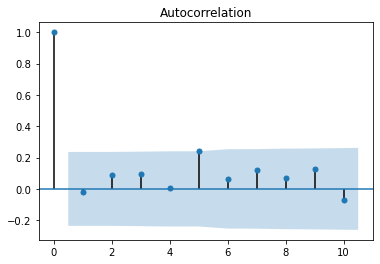

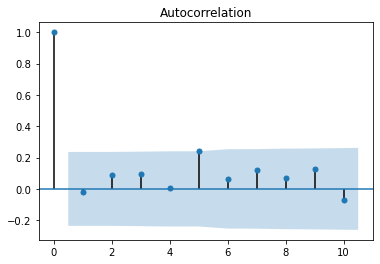

In [5]:
sm.graphics.tsa.plot_acf(ts, lags=10)

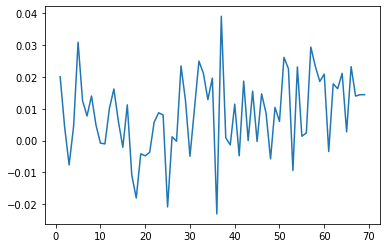

In [6]:
ts.plot()

In [7]:
for h in range(0,10):
    print(ts.autocorr(h))

1.0
-0.017863080690271874
0.0916835934831606
0.09867941633144277
0.007185294744703992
0.2570288565170149
0.06455041838627247
0.13023393734241673
0.07592451447605537
0.13670360738352683


In [33]:
def mets_forecast(rho,Y , max_length):
    if len(Y) < max_length:
        np.append( np.zeros(max_length - len(Y)), Y)
        
    Y = np.flip(Y[-max_length:])
    return -1.0*np.sum([y*rho**h/math.factorial(h) for y,h in zip(Y,range(1,max_length-1))])

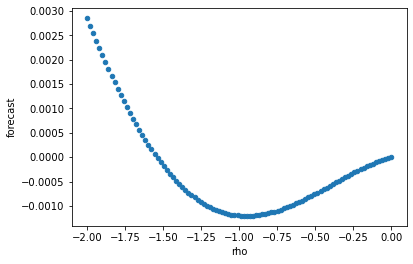

In [36]:
forecast_df = pd.DataFrame(columns= ['rho','forecast'])
forecast_df['rho'] = np.linspace(-2,0,100)
forecast_df['forecast'] = forecast_df['rho'].apply(lambda s: mets_forecast(s,np.array(ts)[:10],10))
forecast_df.plot.scatter(x='rho',y='forecast')

In [39]:
np.array(ts)[0:10]

array([ 0.02009135,  0.00420673, -0.00769231,  0.00444231,  0.03094712,
        0.01252404,  0.00772115,  0.01400481,  0.004875  , -0.00083654])

In [191]:
arma_model = ARIMA(ts, order=(5, 0, 0)).fit()
print(arma_model.params)

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


const     0.008629
ar.L1    -0.018774
ar.L2     0.065195
ar.L3     0.068091
ar.L4     0.011435
ar.L5     0.237619
sigma2    0.000142
dtype: float64


C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [219]:
def theoretical_acf(rho, upper_bound):
    acf = []
    acf_denom = 0.0
    
    for j in range(0,20):
        acf_denom = acf_denom+ ( (rho)**(2j) / (math.factorial(j)*math.factorial(j) ) )


    for h in range(0,upper_bound):
        acf_num = 0.0
        
        for j in range(0,20):
            acf_num = acf_num + ( (rho)**(2j+h) / (math.factorial(j)*math.factorial(j+h) ) )
        
        acf.append( (acf_num/acf_denom).real)
        
    return acf

Text(0.5, 1.0, 'ACF for various values of rho')

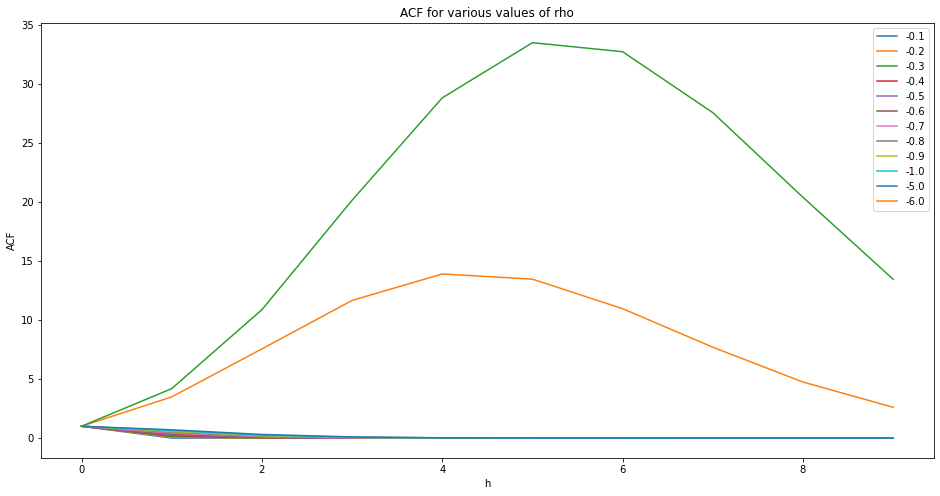

In [222]:
max_h = 10
acf_df = pd.DataFrame(columns = range(0,max_h))

acf_df.loc[0] = np.zeros(max_h)
acf_df.loc[0,0]=1

rho_grid = np.append(np.linspace(.1,1,10),np.array([5.0,6.0]))

for rho in rho_grid:
    acf_df.loc[rho] = np.array(theoretical_acf(rho, max_h))
    
acf_df = acf_df.reset_index()

fig, ax = plt.subplots(figsize = (16,8))

pd.pivot_table(acf_df, columns = 'index').plot(ax = ax)
ax.legend( np.round(-1*rho_grid,1)  )

ax.set_xlabel('h')
ax.set_ylabel('ACF')
ax.set_title('ACF for various values of rho')

In [240]:
def noise_theoretical_acf(rho, upper_bound,var_ratio):
    acf = []
    acf_denom = iv(0,2*rho) + var_ratio 

    for h in range(0,upper_bound):
        acf_num = iv(h,2*rho)      
        acf.append( (acf_num/acf_denom))
        
    return acf

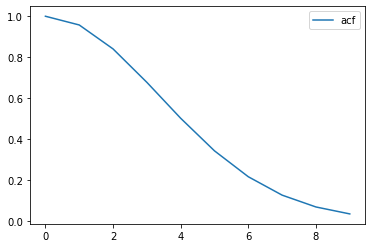

In [241]:
acf_df = pd.DataFrame(columns = ['acf'])
acf_df['acf'] = noise_theoretical_acf(6.0, 10, 4.0)
acf_df.plot()